In [262]:
# used for data gathering + representation
import pandas as pd

# used for data analysis
import numpy as np

# used for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Dataset Overview

[Dataset](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

The data is attempting to predict sales prices for thousands of stores located in Ecuador. The data includes stores, and product information about the products sold at the store, whether the individual item was being promoted, and also the sales numbers. The additional files (all files besides the train, sample_submission, and test), contain information relevant to training your model. This is predicting a continuous value, so this is a regression problem rather than a classification problem.

In [263]:
holiday_event_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
transactions_df = pd.read_csv('transactions.csv')

## training data
training_df = pd.read_csv('train.csv', index_col=0)
testing_df = pd.read_csv('test.csv')

training_df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [264]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


In [265]:
training_df.describe()

,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00
std,1.558579e+01,1.101998e+03,1.221888e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02


## 2. Data Preprocessing

Here we need to process and handle any missing values, as well as inconsistencies, such as mapping the date column and separating it into day, month, and year columns.

In [266]:
stores_nans = []

for each_column in stores_df.columns:
    if stores_df[each_column].hasnans:
        stores_nans.append(each_column)

stores_nans


[]

In [267]:
updated_training_df = training_df.copy()

updated_training_df['date'] = pd.to_datetime(updated_training_df['date'])
updated_training_df['day'] = updated_training_df['date'].map(lambda x: x.day)
updated_training_df['month'] = updated_training_df['date'].map(lambda x: x.month)
updated_training_df['year'] = updated_training_df['date'].map(lambda x: x.year)
updated_training_df.drop(columns=['date'], inplace=True)

updated_training_df = pd.get_dummies(updated_training_df, columns=['family'])

updated_training_df.head()

,store_nbr,sales,onpromotion,day,month,year,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
id,,,,,,,,,,,,,,,,,,,,,
0,1,0.0,0,1,1,2013,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0,1,1,2013,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,0,1,1,2013,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,0,1,1,2013,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0,1,1,2013,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Exploratory Data Analysis (EDA)

This step helps us understand the distribution of features, and also the relationships between them. Identify patterns or anomalies, visualize and analyze the dataset.

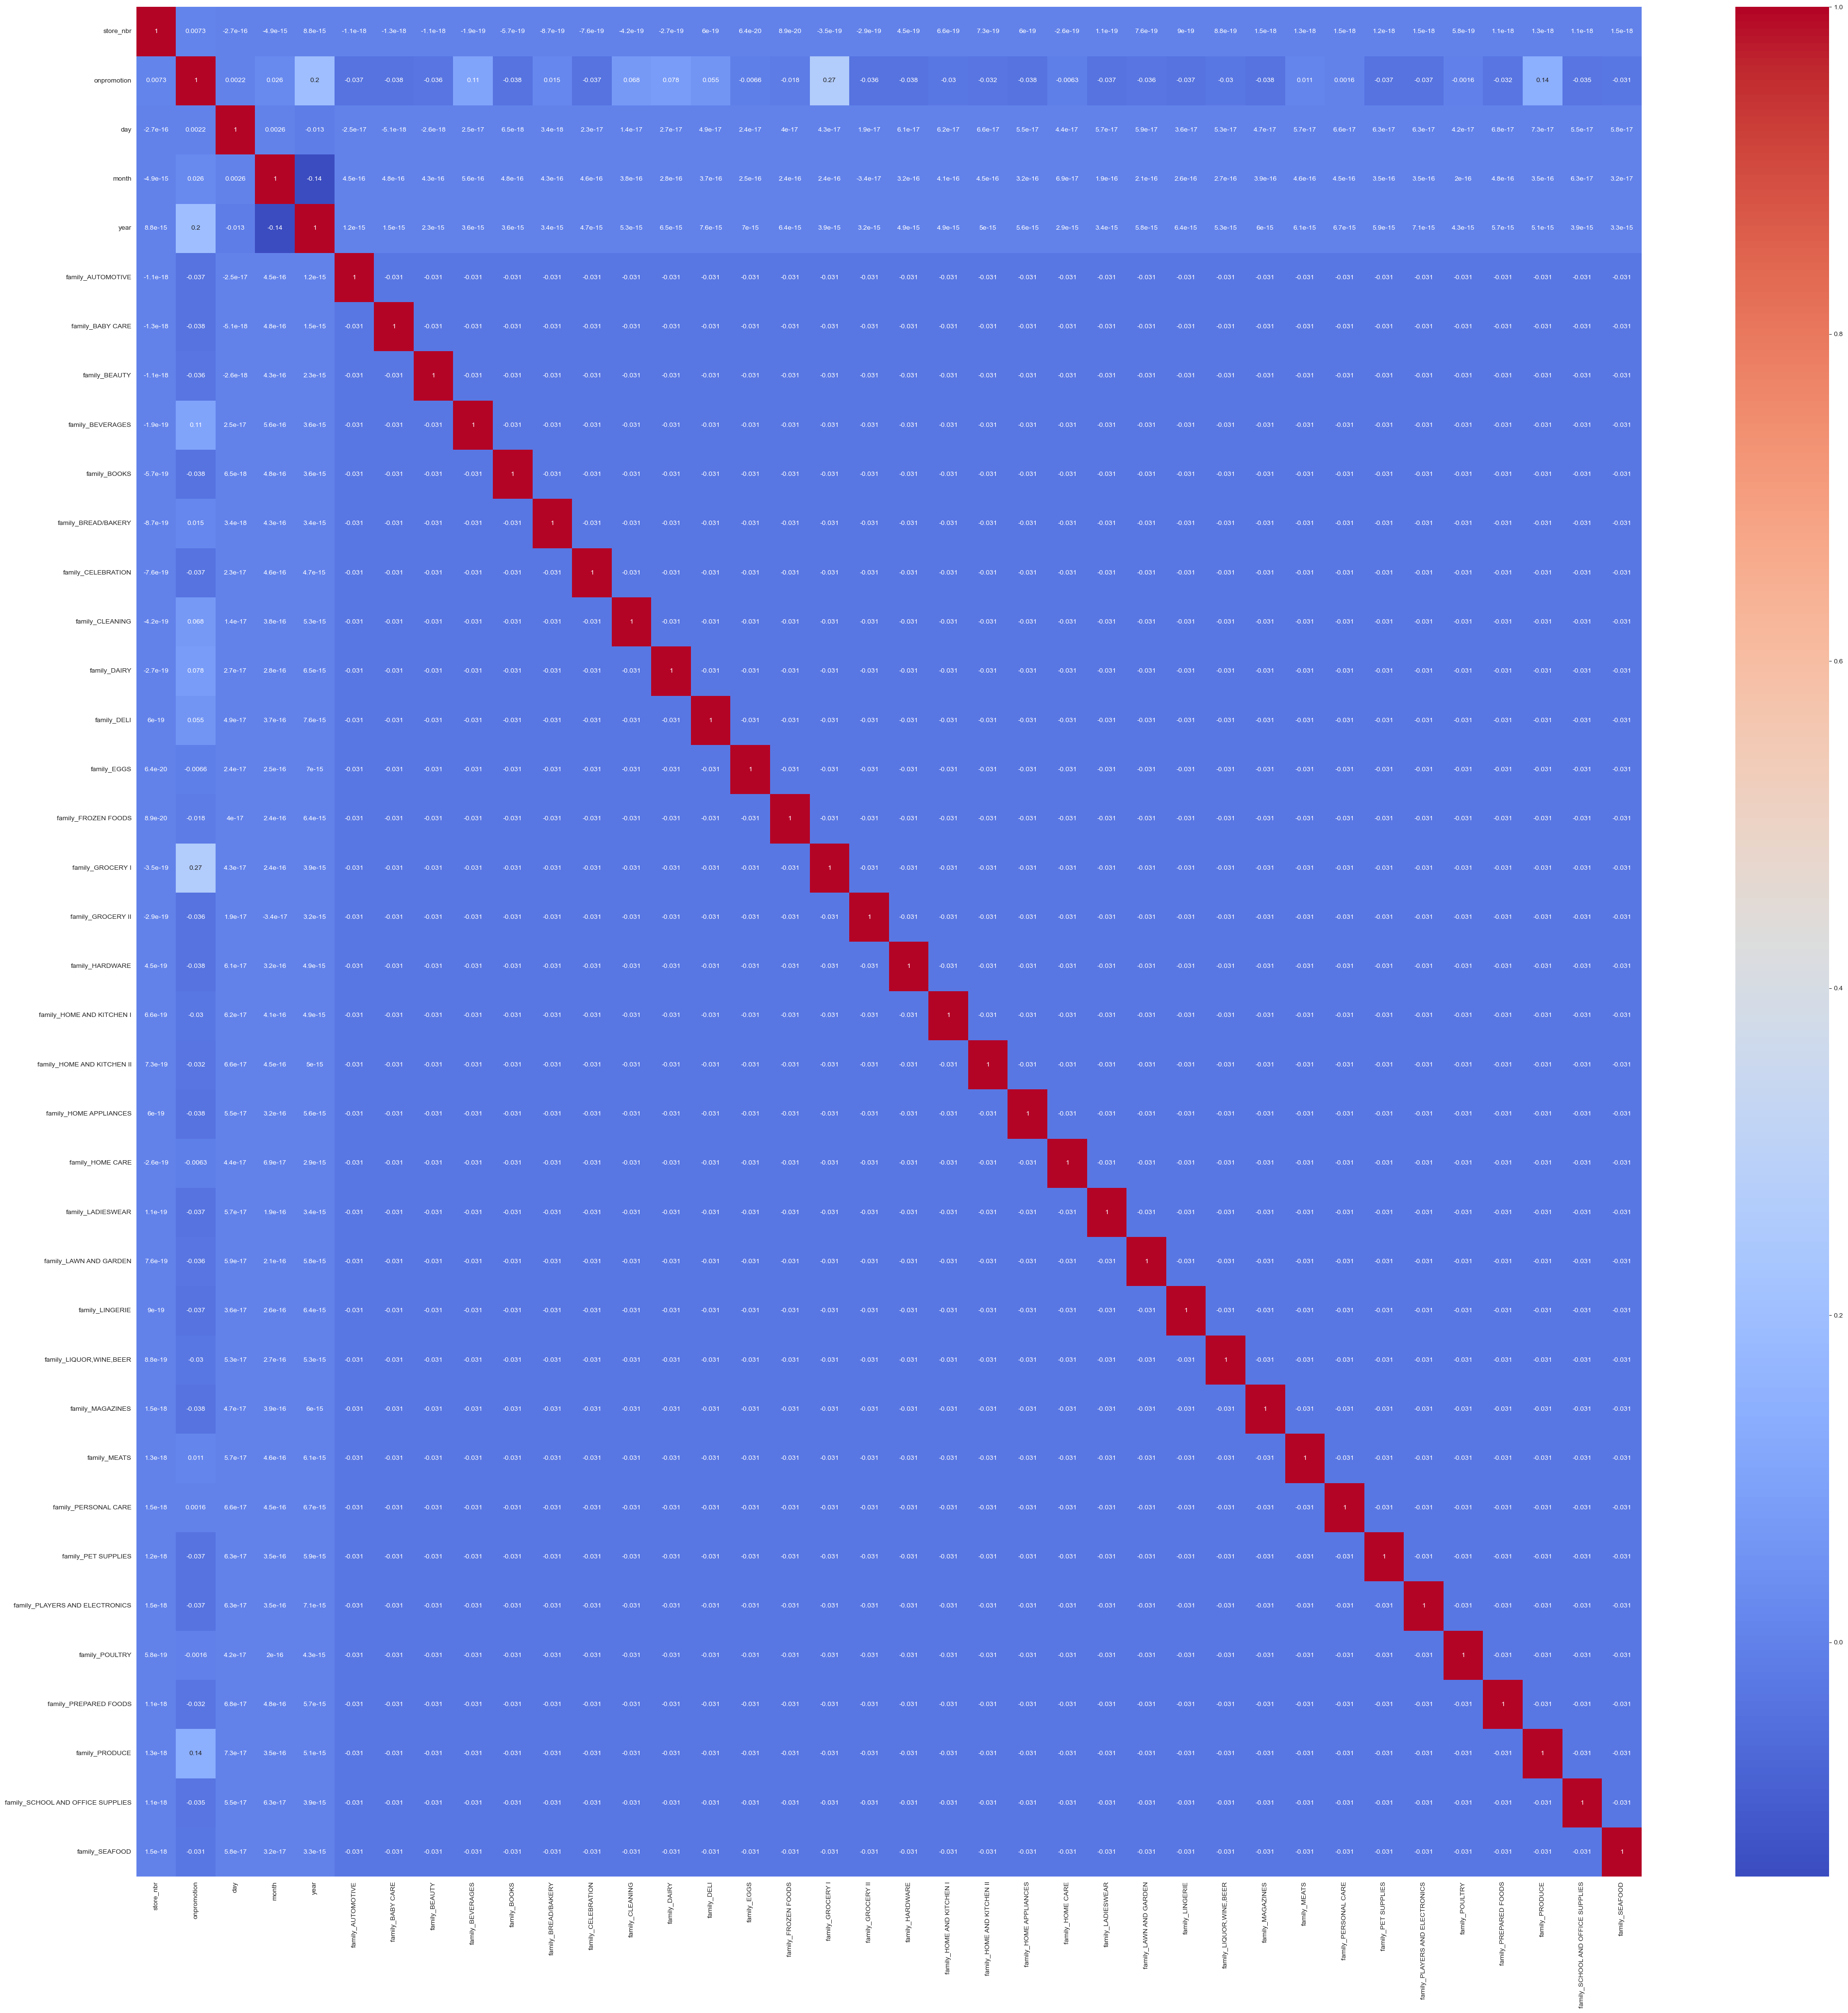

In [268]:
from sklearn.feature_selection import mutual_info_regression

corr_matrix = updated_training_df.drop(columns=['sales']).corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.savefig('correlation_matrix.pdf', format='pdf')

#values = mutual_info_regression(updated_training_df.drop(columns=['sales']), y=updated_training_df['sales'])

['store_nbr', 'sales', 'onpromotion', 'day', 'month', 'year']


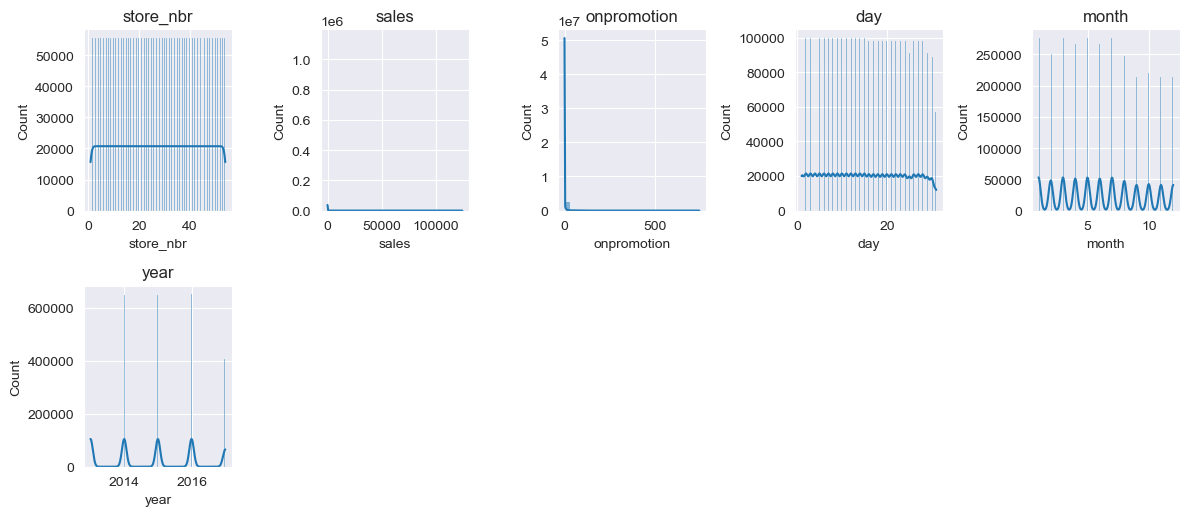

In [269]:
plt.figure(figsize=(12, 10))

numeric_columns = []
for each_col in updated_training_df.columns:
    if updated_training_df[each_col].dtype in ['int64', 'float64']:
        numeric_columns.append(each_col)

print(numeric_columns)

for ind, each_numeric_column in enumerate(numeric_columns):
    plt.subplot(4, 5, ind + 1)
    sns.histplot(updated_training_df[each_numeric_column], kde=True)
    plt.title(each_numeric_column)

plt.tight_layout()
plt.show()

## 4. Feature Engineering

This is where we use the data retrieved from the exploratory data analysis and use that to generate new features or refactor current features

In [270]:
updated_training_df.describe()

,store_nbr,sales,onpromotion,day,month,year,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,...,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00,1.563005e+01,6.207838e+00,2.014838e+03,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,...,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02,3.030303e-02
std,1.558579e+01,1.101998e+03,1.221888e+01,8.794789e+00,3.385668e+00,1.345518e+00,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,...,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01,1.714199e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,8.000000e+00,3.000000e+00,2.014000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,1.600000e+01,6.000000e+00,2.015000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00,2.300000e+01,9.000000e+00,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02,3.100000e+01,1.200000e+01,2.017000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [271]:
## Format all the dates columns in the entire training set

is_last_february = lambda x: x.month == 1 and x.day == 28
is_last_thirty = lambda x: x.month in [4, 6, 10, 11] and x.day == 30

to_day = lambda x: x.day
to_year = lambda x: x.year
to_month = lambda x: x.month
is_payday = lambda x: is_last_february(x) or is_last_thirty(x) or x.day == 31

date_transformers = {
    'day': to_day,
    'year': to_year,
    'month': to_month
}

models_date_transformed = ['oil', 'holiday_events', 'training', 'transactions']

oil_df_copy = oil_df.copy()
holiday_events_copy = holiday_event_df.copy()
training_copy = training_df.copy()
transactions_copy = transactions_df.copy()

oil_df_copy['date'] = pd.to_datetime(oil_df_copy['date'])
holiday_events_copy['date'] = pd.to_datetime(holiday_events_copy['date'])
training_copy['date'] = pd.to_datetime(training_copy['date'])
transactions_copy['date'] = pd.to_datetime(transactions_copy['date'])
training_copy['is_payday'] = training_copy['date'].map(is_payday)

for each_key in date_transformers:
    oil_df_copy[f'{models_date_transformed[0]}_{each_key}'] = oil_df_copy['date'].map(date_transformers[each_key])
    holiday_events_copy[f'{models_date_transformed[1]}_{each_key}'] = holiday_events_copy['date'].map(
        date_transformers[each_key])
    training_copy[f'{models_date_transformed[2]}{each_key}'] = training_copy['date'].map(date_transformers[each_key])
    transactions_copy[f'{models_date_transformed[3]}_{each_key}'] = transactions_copy['date'].map(
        date_transformers[each_key])

oil_df_copy.drop(columns=['date'], inplace=True)
holiday_events_copy.drop(columns=['date'], inplace=True)
training_copy.drop(columns=['date'], inplace=True)
transactions_copy.drop(columns=['date'], inplace=True)

oil_df_copy.columns, holiday_events_copy.columns, stores_df.columns, training_copy.columns, transactions_copy.columns

(Index(['dcoilwtico', 'oil_day', 'oil_year', 'oil_month'], dtype='object'),
 Index(['type', 'locale', 'locale_name', 'description', 'transferred',
        'holiday_events_day', 'holiday_events_year', 'holiday_events_month'],
       dtype='object'),
 Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object'),
 Index(['store_nbr', 'family', 'sales', 'onpromotion', 'is_payday',
        'trainingday', 'trainingyear', 'trainingmonth'],
       dtype='object'),
 Index(['store_nbr', 'transactions', 'transactions_day', 'transactions_year',
        'transactions_month'],
       dtype='object'))

In [272]:
training_copy['cluster'] = np.nan

for ind, each_store_data in training_copy.iterrows():
    found = stores_df[stores_df['store_nbr'] == each_store_data['store_nbr']]
    training_copy.at[ind, 'cluster'] = int(found['cluster'])

training_copy.head()

,store_nbr,family,sales,onpromotion,is_payday,trainingday,trainingyear,trainingmonth,cluster
id,,,,,,,,,
0,1,AUTOMOTIVE,0.0,0,False,1,2013,1,13.0
1,1,BABY CARE,0.0,0,False,1,2013,1,13.0
2,1,BEAUTY,0.0,0,False,1,2013,1,13.0
3,1,BEVERAGES,0.0,0,False,1,2013,1,13.0
4,1,BOOKS,0.0,0,False,1,2013,1,13.0


In [273]:
from sklearn.impute import SimpleImputer

oil_nan_columns = []

for each_column in oil_df.columns:
    if oil_df[each_column].hasnans:
        oil_nan_columns.append(each_column)

impute = SimpleImputer()

oil_df['dcoilwtico'] = impute.fit_transform(oil_df[['dcoilwtico']])

oil_df.head()

,date,dcoilwtico
0,2013-01-01,67.714366
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000


In [274]:
from datetime import datetime

holiday_nan_columns = []

for each_column in holiday_events_copy.columns:
    if holiday_events_copy[each_column].hasnans:
        holiday_nan_columns.append(each_column)

holiday_nan_columns, holiday_events_copy.head()

transferred_type = holiday_events_copy[holiday_events_copy['type'] == 'Transfer']
transferred_holidays = holiday_events_copy[holiday_events_copy['transferred'] == True]
bridge_days = holiday_events_copy[holiday_events_copy['type'] == 'Bridge'].sort_values(
    by=['description', 'holiday_events_day'])

# moving all holidays
for row_label, row in transferred_holidays.iterrows():
    row_id = row.name
    row_locale = row['locale']
    row_locale_name = row['locale_name']
    row_description = row['description']
    row_holiday_day = row['holiday_events_day']
    row_holiday_month = row['holiday_events_month']
    row_holiday_year = row['holiday_events_year']
    found_row = transferred_type[
        (transferred_type['locale'] == row_locale) & (transferred_type['locale_name'] == row_locale_name) & (
                transferred_type['description'] == row_description)]
    found_row_shape = found_row.shape

    if found_row_shape[0] == 0:
        continue

    found_row = found_row.squeeze()

    found_row_day = found_row['holiday_events_day']
    found_row_month = found_row['holiday_events_month']
    found_row_year = found_row['holiday_events_year']
    holiday_events_copy.loc[found_row.name, 'holiday_events_day'] = row_holiday_day
    holiday_events_copy.loc[found_row.name, 'holiday_events_month'] = row_holiday_month
    holiday_events_copy.loc[found_row.name, 'holiday_events_year'] = row_holiday_year


In [280]:
oil_df_copy.head()

,dcoilwtico,oil_day,oil_year,oil_month
0,NaN,1,2013,1
1,93.14,2,2013,1
2,92.97,3,2013,1
3,93.12,4,2013,1
4,93.20,7,2013,1


In [279]:
updated_training_df.columns

Index(['store_nbr', 'sales', 'onpromotion', 'day', 'month', 'year',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')